# Esame Data Science - a.a. 2020/2021

**Christian Uccheddu 800428**

Di seguitono sono proposti gli esercizi per la prova d'esame.
Per presentarsi all'esame è necessario aver implementato una soluzione per tutti e 3 gli esercizi.

1. [Esercizio Time Series](#esercizio1)
2. [Esercizio Deep Learning](#esercizio2)
3. [Esercizio Regressione Polinomiale](#esercizio3)

> Le soluzioni sono basate sui codici presentati dal Prof. Biancini durante le esercitazioni

## Importazione librerie

Importo di seguito tutte le librerie con le relative versioni in modo che sia tutto riproducibile

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import scipy
from dateutil.parser import parse
import pmdarima as pm

import statsmodels
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import seaborn as sns


from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout,AlphaDropout, Conv1D, Flatten, BatchNormalization, Input, GaussianNoise, ReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *

pd.options.mode.chained_assignment = None

print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Scipy version:",scipy.__version__)
print("Seaborn version:",sns.__version__)
print("Pmdarima version:",pm.__version__)
print("Statsmodels version:",statsmodels.__version__)
print("Tensorflow version:",tf.__version__)

Pandas version: 1.2.3
Numpy version: 1.19.2
Matplotlib version: 3.3.4
Scipy version: 1.6.1
Seaborn version: 0.11.1
Pmdarima version: 1.8.0
Statsmodels version: 0.12.2
Tensorflow version: 1.14.0


<a id="esercizio1"></a>
## Esercizio TIme Series

Partiamo dai dati presi dal database Kaggle chiamato Hourly Energy Consumption. In esso sono contenuti dei dati, raccolti da PJM Interconnection, una società che coordina l'acquisto, la vendita e la consegna continua di elettricità all'ingrosso attraverso il mercato dell'energia dai fornitori ai clienti nella regione della Carolina del Sud, USA.

Tutti i file .csv contengono righe con un timestamp e un valore. Il nome della colonna del valore corrisponde al nome del contraente. Il timestamp rappresenta una singola ora e il valore rappresenta l'energia totale, consumata durante quell'ora.

https://www.kaggle.com/robikscube/hourly-energy-consumption

Leggendo il dataset `data/PJME_hourly.csv`, caricare i dati del consumo elettrico. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza).

Infine provare a usare ARIMA per predire il consumo nei prossimi 240 periodi.

### Esplorazione dei dati

In [210]:
#dati = pd.read_csv("data/PJME_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')
#dati.asfreq('H')
dati = pd.read_csv("data/PJME_hourly.csv")
dati = dati.drop("Datetime", axis = 1)
dati

,PJME_MW
0,26498.0
1,25147.0
2,24574.0
3,24393.0
4,24860.0
...,...
145361,44284.0
145362,43751.0
145363,42402.0
145364,40164.0


Guardiamo se ci sono valori nulli

In [211]:
dati.isnull().sum(axis = 0)

PJME_MW    0
dtype: int64

In questo caso non ci sono delle variabili nulle

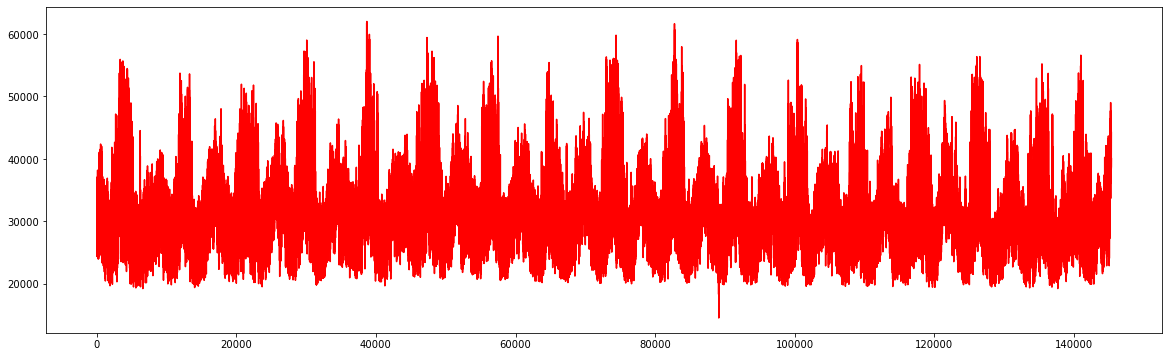

In [212]:
plt.figure(figsize=(20,6))
plt.plot(dati.index, dati.values, color = "red")
plt.show()

Scomponiamo nelle componenti principali

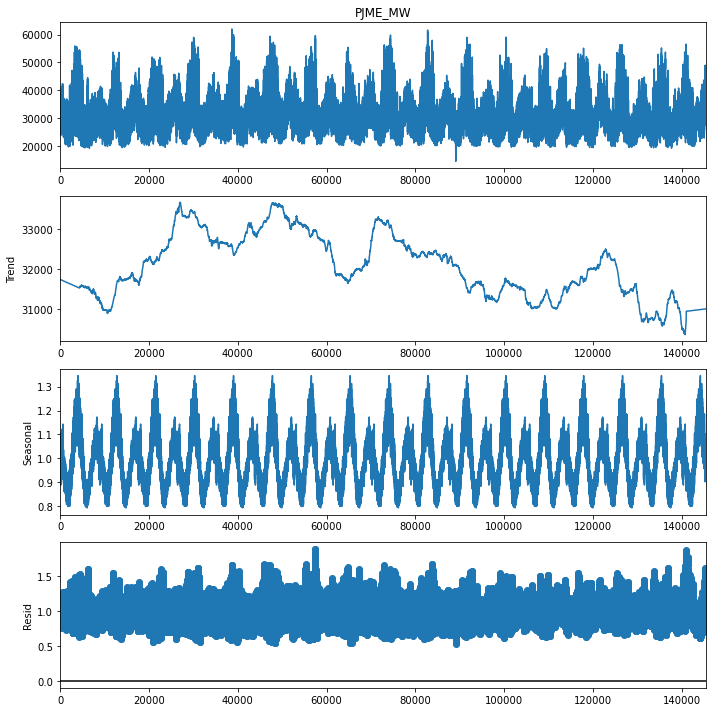

In [213]:
result_mul = seasonal_decompose(dati['PJME_MW'], model='multiplicative', extrapolate_trend='freq', period = 24*365)

plt.rcParams.update({'figure.figsize': (10, 10)})
result_mul.plot()
plt.show()

Text(0, 0.5, 'Residual')

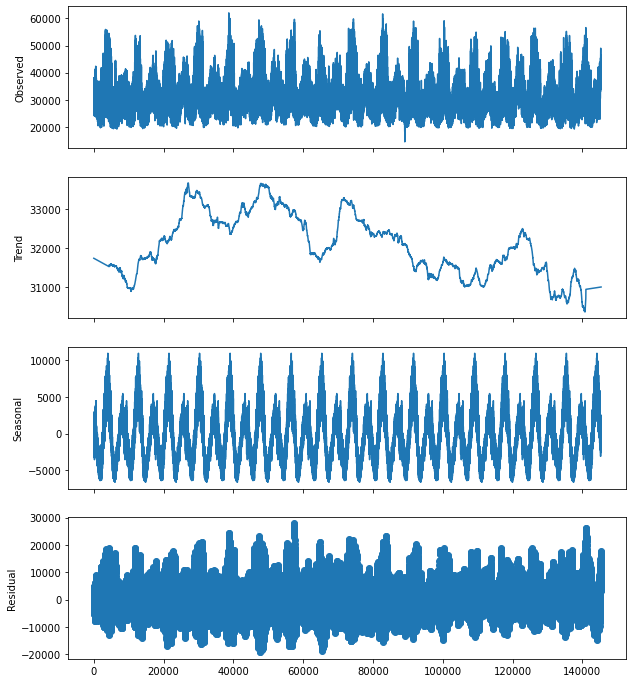

In [214]:
result_add = seasonal_decompose(dati['PJME_MW'], model='additive', extrapolate_trend='freq', period = 24*365)
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,12))

result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')

Creo in anticipo l'indice temporali per i futuri in modo da poterlo utilizzare comodamente all'occorrenza.

In [215]:
future_index = pd.DataFrame(
        {'Datetime': pd.date_range('2018-01-02 01:00:00', '2018-01-12 01:00:00', freq='1H', closed='left')}
     )
future_index.set_index('Datetime', inplace = True)

### Regressione lineare trend

Per prima cosa estrapolo il trend dalla decomposizione. Una volta estratto il trend applichiamo quindi una regressione lineare per cercare di vedere come sta andando. Per farlo fitteremo i dati su tutto il trend e proveremo a vedere come funziona per qualche osservazione in avanti per vedere se è un risultato che ha senso.

In [216]:
future_obs = 240

trend = result_add.trend.values

time = np.linspace(0, trend.shape[0], trend.shape[0])
future = np.linspace(time.shape[0], time.shape[0] + future_obs, future_obs)

print(f"Trend shape: {trend.shape}\nTime shape: {time.shape}\nFuture shape: {future.shape}")

Trend shape: (145366,)
Time shape: (145366,)
Future shape: (240,)


Ora che li abbiamo messi nel formato giusto applichiamo una regressione lineare al trend, osservandolo graficamente ci aspettiamo che venga una intercetta positiva con un coefficiente angolare negativo. Si nota infatti chiaramente come il trend sia decrescente.

In [217]:
reg = linear_model.LinearRegression()

reg.fit(time.reshape(-1,1), trend.reshape(-1,1))

LinearRegression()

In [218]:
predictions = reg.predict(future.reshape(-1,1))
coefficient = reg.coef_
intercept = reg.intercept_

print('Coefficients:', np.round(coefficient, 2))
print('Intercept:', np.round(intercept, 2))

Coefficients: [[-0.01]]
Intercept: [32698.74]


Come notiamo è esattamente ciò che ci aspettavamo

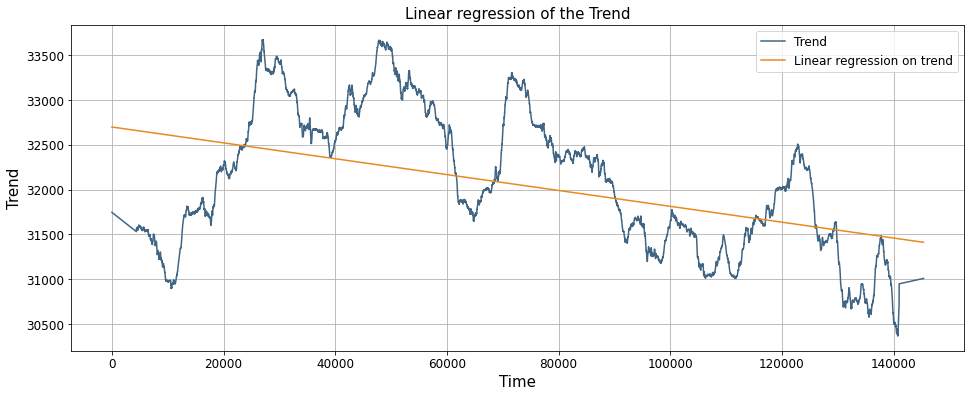

In [219]:
plt.figure(figsize=(16,6))
plt.plot(result_add.trend.index, result_add.trend.values, color = "#416685", label = "Trend")
plt.plot(dati.index, intercept + time*coefficient[0] , color = "#E88920", label = "Linear regression on trend")

plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel("Time", size = 15)
plt.ylabel("Trend", size = 15)
plt.title("Linear regression of the Trend", size = 15)
plt.grid()
plt.legend(fontsize=12, loc='upper right')

### ARIMA

In [221]:
smodel = pm.auto_arima(dati, start_p = 0, start_q = 0,
                       test='adf',
                       max_p = 2, max_q = 2,
                       start_P = 0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2963418.000, Time=1.84 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2550996.319, Time=4.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2785107.560, Time=34.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3434951.825, Time=1.28 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2437574.115, Time=10.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2437498.785, Time=14.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2480779.548, Time=69.75 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2437455.714, Time=25.55 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2458562.449, Time=22.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2449429.199, Time=8.81 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 193.994 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               145366
Model:               SARIMAX(2, 0, 2)   Log Likelihood            -1218721.857
Date:                Thu, 06 May 2021   AIC                        2437455.714
Time:                        18:58:17   BIC                        2437515.036
Sample:                             0   HQIC                       2437473.419
                             - 145366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1700.4231     18.881     90.058      0.000    1663.416    1737.430
ar.L1          1.6885      0.004    435.764      0.000       1.681       1.696
ar.L2         -0.7414      0.004   -209.204      0.000      -0.748      -0.734
ma.L1         -0.0237      0.004     -5.715      0.000      -0.032      -0.016
ma.L2          0.0198      0.005      3.951      0.000       0.010       0.030
sigma2      1.121e+06      0.045   2.52e+07      0.000    1.12e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            660675.07
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+21. Standard errors may be unstable.
"""

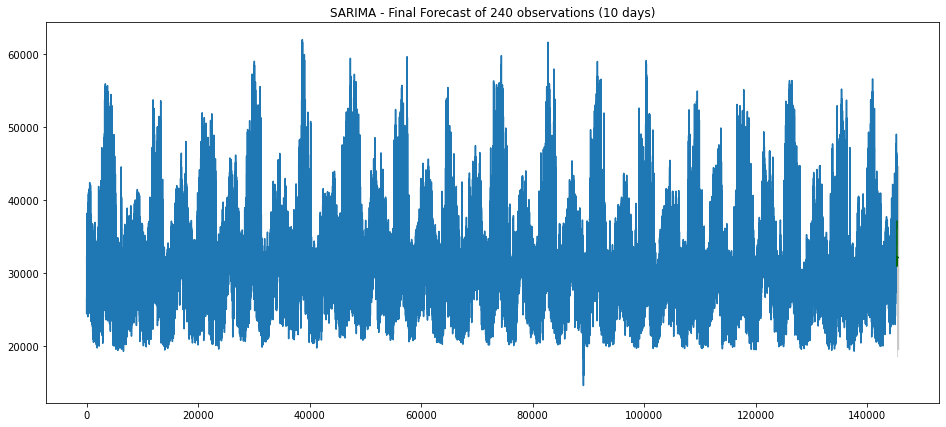

In [226]:
n_periods = 240
fitted, confint = smodel.predict(n_periods = n_periods, return_conf_int = True)
index_of_fc = pd.date_range(dati.index[-1], periods = n_periods, freq = 'MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(dati)

plt.plot(future, fitted_series, color='darkgreen')

plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 240 observations (10 days)")
plt.show()

<a id="esercizio2"></a>
## Esercizio Deep Learning

Creare una rete neurale Deep Learning per predire se un paziende ha una malattia cardiaca o no. Utilizziamo i dati presenti nel dataset linkato qui: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

E disponibile nel file `data/heart.csv`, esploriamo il dataset e proviamo a creare una rete come descritto con Tensorflow.

### Esplorazione variabili

In [130]:
dati = pd.read_csv("data/heart.csv")
dati

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Controlliamo le prime statistiche descrittive, facciamolo ovviamente solo sulle variabili continue

In [131]:
cont_var = ['age', 'trestbps', 'chol',  'thalach', 'oldpeak']
dati[cont_var].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Controlliamo per sicurezza se sono presenti valori nulli.

In [132]:
dati.isnull().sum(axis = 0)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Come possiamo vedere non sono presenti valori nulli all'interno delle colonne, ciò vuol dire che non dobbiamo occuparci di sostituirli. Possiamo dedicarci ora alla produzione di qualche grafico di esplorazione delle variabili. Per prima cosa guardiamo se si tratta di un problema di classificazione sbilanciati

In [133]:
class_0, class_1 = np.bincount(dati['target'])
total = class_0 + class_1
print('Total: {}\nClasse 1: {} ({:.2f}% del totale)\nClasse 0: {} ({:.2f}% del totale)\n'.format(total, 
                                                                                             class_1, 100 * class_1 / total, 
                                                                                             class_0, 100 * class_0 / total))

Total: 303
Classe 1: 165 (54.46% del totale)
Classe 0: 138 (45.54% del totale)



Come vediamo il problema è bilanciato nella classe di target, ciò vuol dire che non sono necessarie ulteriori operazioni. Iniziamo a vedere come si distribuisce la variabile continua **Age**, per farlo useremo un plot che ci consente di divedere le distribuzioni per sesso applicando una funzione di densità di probabilità.

In [134]:
def violin(dati, colonna):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.kdeplot(dati.loc[dati["sex"] == 0][colonna], color='blue', ax=ax)

    x = ax.lines[-1].get_xdata()
    y = ax.lines[-1].get_ydata()

    for p in ax.patches:  
        p.set_height(-p.get_height())
    for l in ax.lines:  
        l.set_ydata(-l.get_ydata())

    ax.fill_between(x, 0, -y, color='blue', alpha=0.3)

    sns.kdeplot(dati.loc[dati["sex"] == 1][colonna], shade = True, color = "violet")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
    ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])

    ax.set_yticks(ticks)
    ax.set_yticklabels([f'{abs(t):.2f}' for t in ticks])
    ax.spines['bottom'].set_position('zero')
    plt.legend([],[], frameon=False)

    plt.xlabel(r"Value", horizontalalignment = "right", x=1.0, size = 15)
    plt.yticks(size = 12)
    plt.legend([],[], frameon=False)
    plt.ylabel("Density of probability", fontsize = 15)
    plt.title("{}".format(colonna), fontsize = 20)

Applichiamo quindi la funzione creata alle variabili continue presenti all'interno del dataset

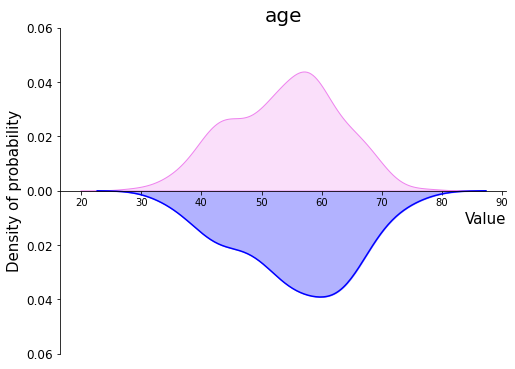

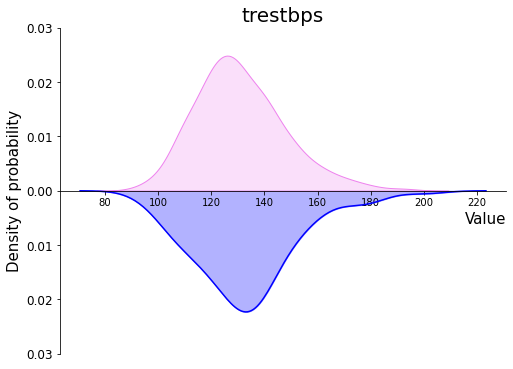

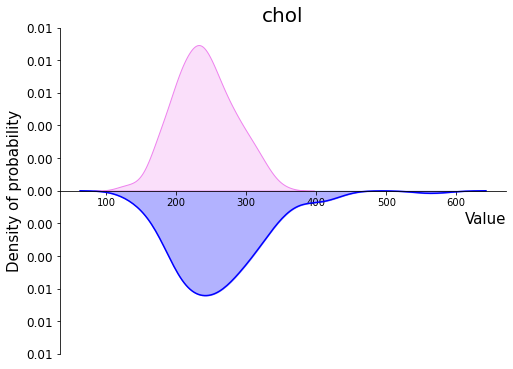

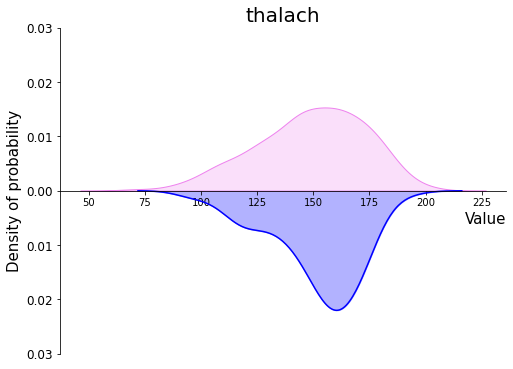

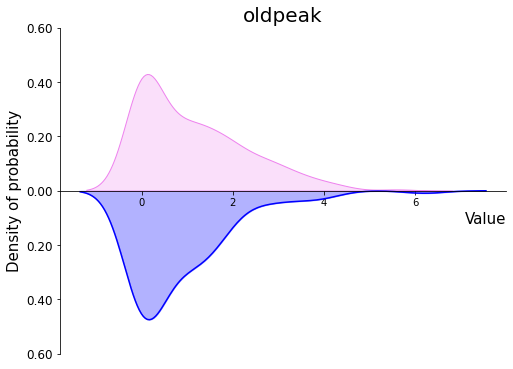

In [135]:
for variabile in cont_var: 
    violin(dati, variabile)

Come si può notare non sono presenti differenze tra le distribuzioni delle variabili per sesso. Guardiamo anche un pairplot per vedere come sono le relazioni tra le variabili.

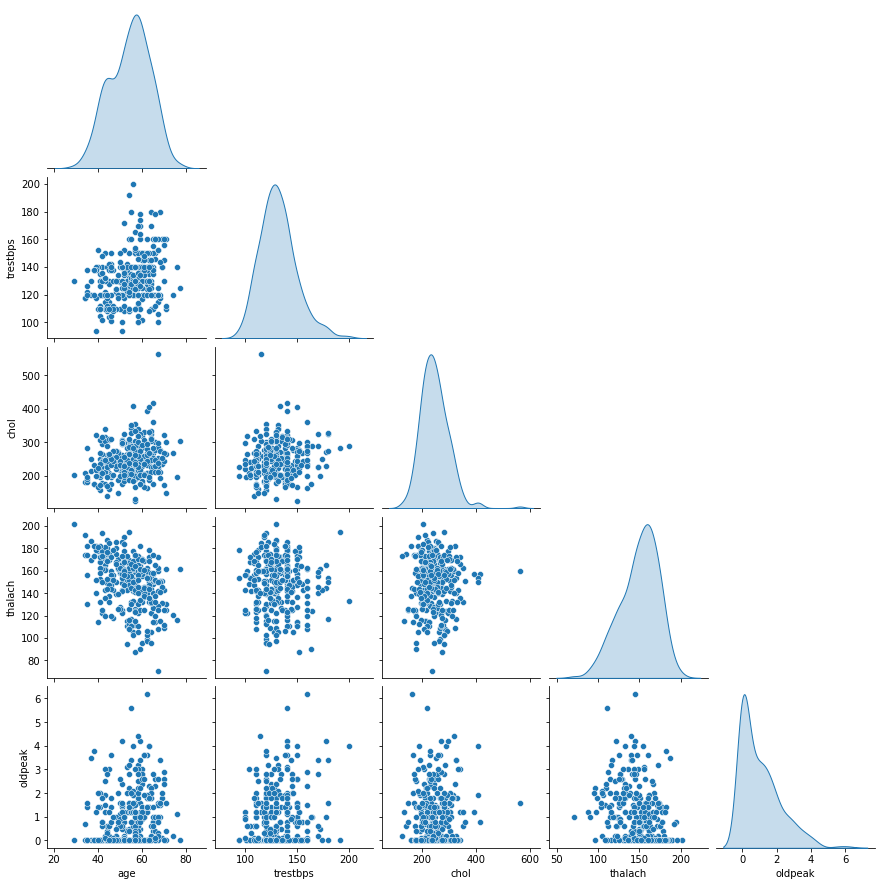

In [136]:
sns.pairplot(dati[cont_var], corner= True, palette = "#416685", diag_kind="kde")

Per vedere meglio queste correlazioni è più utile produrre una matrice di correlazione. Creiamo quindi una correlation matrix che ci permetta di visualizzare i coefficienti di correlazione tra le variabili. In particolare decidiamo di mostrare solo le correlazioni che presentano un p-value < 0.05.

In [137]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=0, linecolor='black', cbar_kws={'orientation': 'vertical'})
    plt.xticks(size = 15)
    plt.yticks(size = 15, rotation = 0)

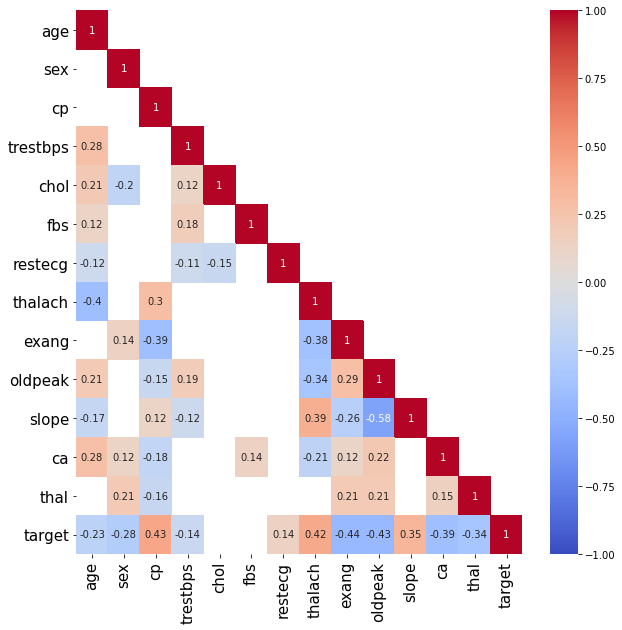

In [138]:
corr = dati.corr()      
p_values = calculate_pvalues(dati)
mask = np.invert(np.tril(p_values<0.05))
plot_cor_matrix(corr,mask)

Come vediamo ci sono un bel po' di correlazioni tra le variabili. Ciò ci suggerische potremmo fare a meno di alcune variabili per questo problema di classificazione. Si potrebbe pensare quindi di applicare tecniche di dimensionality reduction quali la PCA o la UMAP (che a differenza della PCA è un metodo non lineare) ma non è lo scopo di questo lavoro.

### Preprocessing

In questa fase dobbiamo occuparci del preprocessing delle variabili, quindi dobbiamo scalare le variabili continue e rendere categoriche le variabili categoriche. Dobbiamo inoltre dividere in train e validation le variabili in modo da poter addestrare il modello e successivamente valutarne le performance. Creiamo per prima cosa la funzione che permette di effettuare le operazioni di preprocessing dei dati. In particolare la funzione preprocess data consente di definire scalare le variabili continue e di categorizzare le variabili categoriche in modo che siano utilizzabili da tensorflow.

In [139]:
def preprocess_data(df, cont_var, cat_var):
    
    ct = ColumnTransformer([
            ('continuos', StandardScaler(), cont_var),
            ('categorical', OneHotEncoder(), cat_var)],
            remainder='passthrough')

    df = ct.fit_transform(df)

    return df

Applichiamo questa funzione al dataset in modo da scalare le variabili

In [140]:
cont_var = ['age', 'trestbps', 'chol',  'thalach', 'oldpeak']
cat_var = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

dati_scaled = preprocess_data(dati, cont_var, cat_var)

print("Le dimensioni del dataset dopo le operazioni di preprocessing sono:", dati_scaled.shape)

Le dimensioni del dataset dopo le operazioni di preprocessing sono: (303, 31)


Dividiamo quindi in train e validation il dataset. Per farlo settiamo un seed in modo che i risultati siano riproducibili. Decidiamo inoltre che la proporzione sarà 80\% / 20\% a causa della mancanza di altri dati. Questa proporzione ci consente infatti di avere diversi dati su cui addestrare il modello ma di averne abbastanza su cui testare.
Trasformiamo inoltre in numpy array in modo da poter passare i vettori a keras senza che nascano warning di alcun tipo.

In [141]:
x_train, x_val, y_train, y_val = train_test_split(dati_scaled[:, :-1], dati_scaled[:, -1], test_size = 0.2, random_state = 42)
x_train = np.array(x_train)
x_val = np.array(x_val)

y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 2)

print(f"x train shape: {x_train.shape}\ny train shape: {y_train.shape}\nx val shape: {x_val.shape}\ny val shape: {y_val.shape}")

x train shape: (242, 30)
y train shape: (242, 2)
x val shape: (61, 30)
y val shape: (61, 2)


Come vediamo tutti i vettori sono stati trasformati nel modo corretto, sia dal punto di vista della numerosità che dal punto di vista delle colonne. Il numero di colonne è infatti aumentato a causa delle trasformazion che abbiamo applicato alle variabili categoriche. Ricordiamo inoltre che abbiamo trasformato anche la variabile di target in un oggetto **categorical** di keras poiché keras lavora meglio con questo tipo di variabili.

### Rete neurale

Definiamo quindi la rete neurale. Visto che sono presenti pochi dati cerchiamo di costruire una rete con pochi parametri. Aggiungiamo inoltre dei layer di Batch Normalization per aiutare a non avere dell'overfitting. Lasciamo di seguito solo il modello che ha funzionato meglio dopo diversi tentativi per non appesantire troppo il notebook.

In [192]:
model = Sequential()
model.add(Input(shape = x_train.shape[1]))
model.add(Dense(16, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation = 'softmax'))
model.add(BatchNormalization())
model.add(Dense(2))

model.compile(loss = losses.binary_crossentropy,
            optimizer = 'adam',
            metrics = ['acc'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                496       
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
batch_normalization_9 (Batch (None, 8)                 32        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 18        
Total params: 746
Trainable params: 698
Non-trainable params: 48
_________________________________________________________________
None


Definiamo a parte gli iperparametri del modello; in particolare:

- min_delta: definisce l'intervallo di cui deve diminuire la loss function nel numero di *p_epochs* per attivare la funzione early stopping.
- p_epochs: definisce il numero di epochs in cui la funzione di loss non deve diminuire di min_delta per attivare la funzione di early stopping.
- n_epochs: il numero di epoche da far fare al classificatore
- batch: la batch size del modello
- learning_rate: il learning rate del modello

Tutti questi parametri sono stati settati empiricamente.

In [201]:
min_delta = 0.01
p_epochs = 50
n_epochs = 300
batch = 128
learning_rate = 0.003

Definiamo quindi un callback di early stopping per fermare il modello nel momento in cui la loss function sul validation set non sta più scendendo. Potevano essere utilizzati diversi callback diversi ma sarebbero stati inutili nel nostro caso.

In [202]:
early_stop = EarlyStopping(monitor='val_loss', min_delta = min_delta,
                        patience = p_epochs, verbose = 0)

Fittiamo quindi il modello sui dati di train in modo da poter successivamente fare le predizioni.

In [203]:
history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = n_epochs, initial_epoch = 0,
                    batch_size = batch, shuffle = True,
                    callbacks=[early_stop])

Train on 242 samples, validate on 61 samples
Epoch 1/300
242/242 [==============================] - 0s 34us/sample - loss: 3.3483 - acc: 0.6612 - val_loss: 2.6516 - val_acc: 0.5492
Epoch 2/300
242/242 [==============================] - 0s 36us/sample - loss: 3.2982 - acc: 0.6694 - val_loss: 2.6453 - val_acc: 0.5574
Epoch 3/300
242/242 [==============================] - 0s 32us/sample - loss: 3.2694 - acc: 0.6694 - val_loss: 2.6406 - val_acc: 0.5574
Epoch 4/300
242/242 [==============================] - 0s 32us/sample - loss: 3.2693 - acc: 0.6694 - val_loss: 2.6368 - val_acc: 0.5492
Epoch 5/300
242/242 [==============================] - 0s 48us/sample - loss: 3.2977 - acc: 0.6653 - val_loss: 2.6379 - val_acc: 0.5492
Epoch 6/300
242/242 [==============================] - 0s 44us/sample - loss: 3.2877 - acc: 0.6798 - val_loss: 2.7132 - val_acc: 0.5492
Epoch 7/300
242/242 [==============================] - 0s 37us/sample - loss: 3.2902 - acc: 0.6818 - val_loss: 2.7086 - val_acc: 0.5328
Epo

Come notiamo si è attivata la funzione di early stopping che ci ha aiutato a prevenire l'overfitting. Facciamo predire al classificatore i valori in modo da poterli utilizzare per confrontare con i valori veri. Ricordiamo che l'output del nostro modello sarà un vettore di due entrate per ogni record, la prima entrata è uguale al valore della funzione softmax per la classe 0 mentre la seconda entrata è uguale al valore della funzione softmax per la classe 1. Scegliamo quindi di assegnare a quella osservazione la classe che ottiene il valore di softmax più alto.

In [204]:
pred = model.predict(x_val)
pred = np.argmax(pred, axis=1)

### Risultati

Definiamo di seguito la funzione che permette di mostrare la loss function e l'accuratezza ottenuta dal modello in fase di addestramento sia sull'insieme di train che sull'insieme di validation. Questo grafico è molto utile in quanto ci permette di vedere se si sta presentando over fitting ed eventualmente correggere il modello.

In [205]:
def acc_loss(history):
    fig = plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train", color = "#416685")
    plt.plot(history.history['val_loss'], label="Validation", color = "#E88920")
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'], label = "Train", color = "#416685")
    plt.plot(history.history['val_acc'], label="Validation", color = "#E88920")
    plt.legend(fontsize=12, bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15)

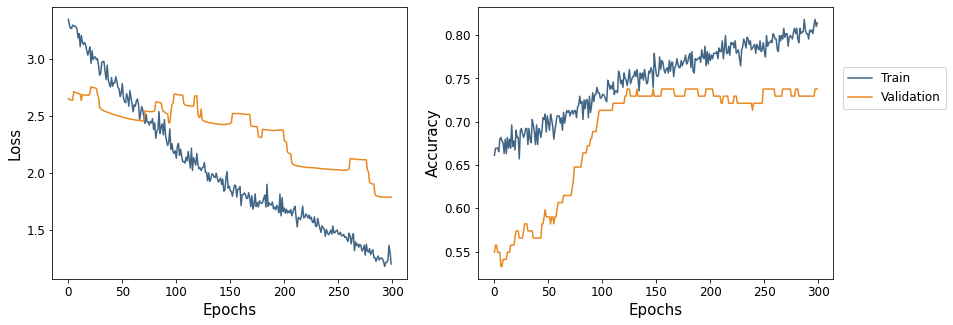

In [206]:
acc_loss(history)

Come possiamo notare dai grafici relativi alla loss e alla accuracy non è presente tantissimo overfitting. La curva per il validation set infatti sta poco staccata da quella del training set lasciando supporre che avvenga un effettivo apprendimento. Proponiamo di seguito il classification report relativo a questo problema di classificazione per vedere i risultati.

In [207]:
report = classification_report(np.argmax(y_val, axis=1), pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.89      0.75      0.81        32

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.83      0.82      0.82        61



Come possiamo notare tutte le metriche sono molto buone. Per essere sicuri che il classificatore non stia sparando una sola classe (dovremmo già esserne sicuri quando la precision e la recall delle due classi) proponiamo la matrice di confusione calcolata sui valori del validation set.

Text(0.5, 1.0, 'Confusion matrix')

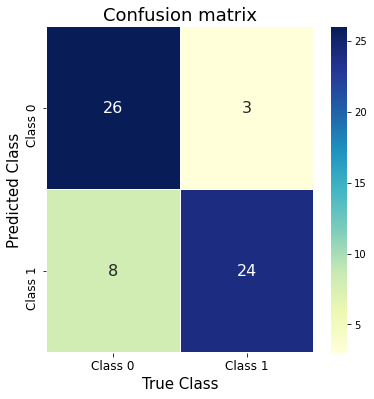

In [208]:
cm = confusion_matrix(np.argmax(y_val, axis=1), pred)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Class 0', 'Class 1']) 
ax.xaxis.set_ticklabels(['Class 0', 'Class 1']) 

plt.title("Confusion matrix", size = 18)

Come possiamo vedere anche graficamente la maggior parte dei valori viene assegnata alla classe corretta il ché vuol dire che il nostro classificatore riesce a distinguere bene le due classi. Probabilmente questo classificatore potrebbe essere migliorato facendolo lavorare su un numero maggiore di dati; avendo più dati inoltre si potrebbe aumentare anche il numero di parametri della rete sfruttando a pieno i metodi del Deep Learning.

<a id="esercizio3"></a>
## Esercizio regressione polinomiale

Leggendo il dataset `data/position_salaries.csv` effettuare una regressione dei dati di salario in base al livello (espresso nella forma di anni di esperienza).

In [177]:
dati = pd.read_csv("data/position_salaries.csv")
dati

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000
5,Region Manager,6,150000
6,Partner,7,200000
7,Senior Partner,8,300000
8,C-level,9,500000
9,CEO,10,1000000


Come possiamo vedere anche ad occhio non ci sono valori mancanti. Come da prassi partiamo con il vedere come sono legate gli anni di esperienza al salario.

### Esplorazione variabili

Per prima cosa utilizziamo quindi la funzione reg_plot di seaborn in combinazione a statsmodel che ci consente di performare una regressione lineare sui dati. Visto che siamo in fase di esplorazione dei dati non ci occuperemo di guardare ordini maggiori. Nella legenda del grafico inseriamo inoltre il p-value della regressione, l'indice $r^2$ e l'equazione della retta che descrive la relazione che intercorre tra le due variabili

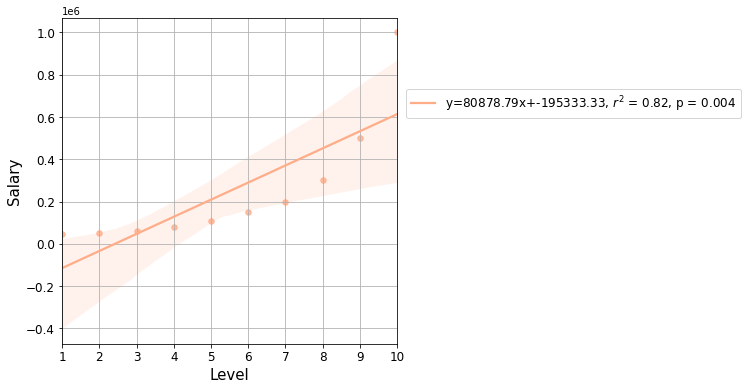

In [178]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dati['Level'], y = dati['Salary'])

plt.figure(figsize = (6,6))
sns.regplot(x = dati['Level'], y = dati['Salary'], scatter_kws={"s": 30}, ci = 95, color = "#FFAD89", order = 1,
            line_kws={'label': r"y={0:.2f}x+{1:.2f}, $r^2$ = {2:.2f}, p = {3:.1g}".format(slope, intercept, r_value, p_value)})
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel("Level", size = 15)
plt.ylabel("Salary", size = 15)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')

Come vediamo il p-value è inferiore al valore di 0.05, ciò vuol dire che la relazione di linearità tra le variabili è statisticamente significativa. Inoltre il valore di $r^2$ è già molto alto, il ché lascia supporre che inserendo anche degli ordini maggiori si possa trovare un modello che riesca a performare meglio. Dedichiamoci quindi nella prossima sottosezione ad approfondire le regressioni polinomiali

### Regressioni polinomiali

Costruiamo quindi la funzione **custom_reg**. Come si può notare questa funzione consente di applicare un regressione lineare specificando la variabile indipendente di partenza e la variabile dipendente. In particolare sono presenti inoltre altri parametri che permettono di estendere questa funzione in modo da inserire altri ordini. In particolare:

- **x**: la variabile indipendente da considerare

- **y**: la variabile dipendente 

- **max_order**: consente di definire il grado della regressione polinomiale a cui arrivare. Vengono quindi create (*max_order - 1*) colonne che contengono la variabile dipendente elevata a tutti i gradi intermedi. Ad esempio definendo max_grad = 3 verranno aggiunte 2 colonne al dataset iniziale. La prima conterrà $x^2$ mentre la seconda conterrà $x^3$. Il valore di default è 3 per creare una regressione polinomiale cubica.

- **exp**: consente di creare una colonna che contiene $e^{x}$. Di default non viene creata nessuna colonna

- **log**: consente di creare una colonna che contiene $log(x)$. Di default non viene creata nessuna colonna

- **custom_func**: consente di creare una colonna che contiene una funzione customizzabile dall'utente. Di default non viene creata nessuna colonna

Nella sua massima generalità il modello sarà quindi:

$$ \hat{y} = \beta_0 + \sum_{i = 1}^{max\_order}\left( \beta_i x^i \right) + \beta_{exp} e^{x} + \beta_{log} \log{x} +  \beta_{cust} custom\_func(x) $$
Come descritto in precedenza i valori di default consentiranno di poter effettuare solo la regressione polinomiale come richiesto dall'esercizio. Questa funzione permette inoltre di ritornare diverse cose:

- *independent_arr:* array della variabile dipendente con le relative colonne create all'interno della funzione.

- *predictions:* array delle predizioni fatte dal modello, in questo caso avendo solo 10 dati non aveva senso separare in train e test

- *coefficient:* i coeffiecienti $\beta_i, \beta_{exp}, \beta_{log}, \beta_{cust}$ del modello

- *intercept:* l'intercetta $\beta_0$ del modello

- *mae:* il Mean Absolute Error calcolato tra predizioni e valori veri tramite: 

$$ MAE = \frac{1}{\# obs} \sum_{i = 1}^{\# obs}\left| \hat{y}_i - y_i \right|  $$

- *r2:* l'indice $r^2$ ottenuto dal modello

In [179]:
def custom_regr(x, y, max_order = 3, exp = False, log = False, custom_func = False): 
    
    assert max_order != 0, "Devi inserire un valore di max_order > 0"
        
    independent_arr = np.ones((len(x), max_order))
    independent_arr[:,0] = x
    dependent = np.array(y).reshape(-1, 1)

    for i in range(1, max_order):
        independent_arr[:,i] = x ** (i + 1) 

    if exp:
        exp_fun = np.ones((independent_arr.shape[0], 1))
        exp_fun[:,0] = np.exp(x)
        independent_arr = np.append(independent_arr, exp_fun, axis=1)
    if log:
        log_fun = np.ones((independent_arr.shape[0], 1))
        log_fun[:,0] = np.log(x)
        independent_arr = np.append(independent_arr, log_fun, axis=1)
    
    if custom_func:
        cust_fun = np.ones((independent_arr.shape[0], 1))
        cust_fun[:,0] = custom_func(x)
        independent_arr = np.append(independent_arr, cust_fun, axis=1)
    reg = linear_model.LinearRegression()
    
    reg.fit(independent_arr,  y)
    
    predictions = reg.predict(independent_arr)
    coefficient = reg.coef_
    intercept = reg.intercept_
    mae = mean_absolute_error(predictions,  y)
    r2 = r2_score(predictions,  y)
    
    print('Coefficients:', np.round(coefficient, 2))
    print('Intercept:', round(intercept, 2))
    print('Mean Absolute Error: {0:.2f}'.format(mae))
    print('Coefficient of determination: {0:.2f}'.format(r2))

    return independent_arr, predictions, coefficient, intercept, mae, r2

Di seguito proponiamo anche l'esempio di una funzione customizzabile da poter passare come parametro a custom_func

In [180]:
def cust_fun(x):
    return np.sin(x)

Richiamiamo quindi le fa funzione che abbiamo creato in modo da farci ritornare tutti i parametri. Utilizziamo come benchmark una regressione polinomiale cubica del tipo:

$$ \hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 $$

Per come è stata costruita la funzione ci verranno quindi ritornati l'intercetta $\beta_0$ e i valori dei coefficienti delle potenze di x: $\beta_1, \beta_2, \beta_3$ sotto forma di numpy array.

In [181]:
arrayfin, pred, coef, inter, mae, r2 = custom_regr(dati['Level'], dati['Salary'], max_order = 3, 
                                                   exp = False, log = False, custom_func = False)

Coefficients: [180664.34 -48548.95   4120.05]
Intercept: -121333.33
Mean Absolute Error: 34790.21
Coefficient of determination: 0.98


Come notiamo vengono stampati a schermo tutti i valori descritti nel paragrafo precedente. Utilizzando solo una funzione di fitting cubica si riesce a raggiungere un valore di $r^2$ di 0.98 che è un valore veramente alto. Disegniamo in uno scatter plot le previsioni rispetto ai valori veri. Ovviamente più le previsioni si adattano ai valori veri più i punti sullo scatter plot tenderanno a stare sulla diagonale. Proponiamo quindi anche la retta di regressione lineare.

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


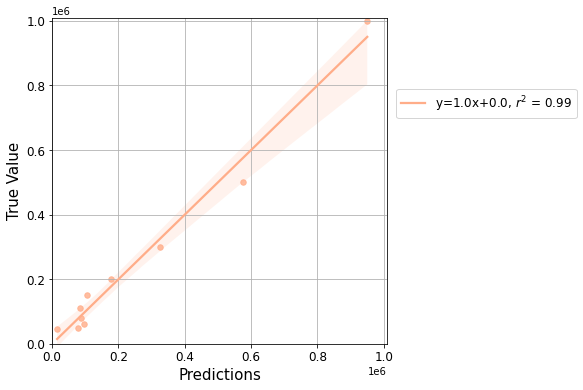

In [182]:
slope, intercept, r_value, p_value, std_err = stats.linregress(pred.reshape(1,-1), y = dati['Salary'])

fig, ax = plt.subplots(figsize = (6, 6))

sns.regplot(x = pred.reshape(1,-1), y = dati['Salary'], scatter_kws={"s": 30}, ci = 95, color = "#FFAD89", order = 1,
            line_kws={'label': r"y={0:.1f}x+{1:.1f}, $r^2$ = {2:.2f}".format(slope, intercept, r_value)})
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.xlim(0, 1.01e6)
plt.ylim(0, 1.01e6)

ax.ticklabel_format(axis = 'both', style = 'sci', scilimits = (0,0))

plt.xlabel("Predictions", size = 15)
plt.ylabel("True Value", size = 15)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')

Come descritto in precedenza  l'accordo tra le previsioni e i dati reali è pressoché perfetto, si ha infatti che il coefficiente angolare della retta di regressione lineare è 1 con ordinata all'origine nulla. Osservando l'intervallo di confidenza al 95\% costruito intorno alla retta si vede infatti che quasi tutti e 10 i valori stanno dentro l'intervallo, confermando quindi la bontà del modello.